# Lending Club Case Study

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
from warnings import filterwarnings

In [98]:
filterwarnings("ignore")

# Some constants/lists that are used throughout the code.
emp_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years","7 years", "8 years", "9 years", "10+ years"]
months = ["Jan","Feb","Mar","Apr","May",'Jun',"Jul","Aug","Sep","Oct",'Nov',"Dec"]

### Custom functions

In [99]:
def remove_perc(val):
    try:
        val = val.replace("%","")
        return float(val)
    except AttributeError:
        #some values do not have percentage sign, thus there is no need to convert the value.
        new_val = float(val)
        return new_val


---

In [100]:
#Importing the complete dataset.
master = pd.read_csv("loan.csv")
print(master.shape)

(39717, 111)


In [101]:
#Finding percentage of null or missing values
null_perc = round(100*(master.isnull().sum()/len(master.index)), 2)
#Printing columns which have more than 0% missing values
null_perc[ null_perc > 0 ]

emp_title                      6.19
emp_length                     2.71
desc                          32.58
title                          0.03
mths_since_last_delinq        64.66
                              ...  
tax_liens                      0.10
tot_hi_cred_lim              100.00
total_bal_ex_mort            100.00
total_bc_limit               100.00
total_il_high_credit_limit   100.00
Length: 68, dtype: float64

In [292]:
master.nunique().sort_values().head()

mths_since_last_major_derog    0
application_type               1
policy_code                    1
collections_12_mths_ex_med     1
initial_list_status            1
dtype: int64

A few columns have a single value which does not help in analysis.

- pymnt_plan
- initial_list_status
- collections_12_mths_ex_med
- policy_code
- acc_now_delinq
- application_type
- pub_rec_bankruptcies
- tax_liens 
- delinq_amnt

The features are only used after the loan has been approved and then the applicants are kept under monitoring.

List of post-approval features: <br>
- delinq_2yrs
- revol_bal
- out_prncp
- total_pymnt
- total_rec_prncp
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt
- next_pymnt_d
- chargeoff_within_12_mths
- mths_since_last_delinq
- mths_since_last_record


At the end of this, we have 50 columns that are of value for analysis. 

In [293]:
cols_use = ["id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade",
"emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan",
"desc","purpose","title","addr_state","dti","earliest_cr_line","delinq_2yrs","earliest_cr_line","inq_last_6mths",
"mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status",
"out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee",
"recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d",
"collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type"]

In [296]:
master = pd.read_csv("loan.csv",usecols=cols_use)
print(master.shape)
master.head()

(39717, 50)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,1077501,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,NaN,...,0.00,0.00,Jan-15,171.62,NaN,May-16,0.00,NaN,1,INDIVIDUAL
1,1077430,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,Ryder,...,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.00,NaN,1,INDIVIDUAL
2,1077175,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,NaN,...,0.00,0.00,Jun-14,649.91,NaN,May-16,0.00,NaN,1,INDIVIDUAL
3,1076863,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,...,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.00,NaN,1,INDIVIDUAL
4,1075358,3000,3000,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,...,0.00,0.00,May-16,67.79,Jun-16,May-16,0.00,NaN,1,INDIVIDUAL


In [295]:
## Creating a separate dataframe for the applicants that have been written off, thus making LendingClub incur losses.
charged_off = master[master["loan_status"] == "Charged Off"]
charged_off.shape

(5627, 50)

## Cleaning/Transforming the dataset:

In [297]:
# Interest rate:
# Removing the percentage sign and converting to float.
master["int_rate"] = master["int_rate"].apply(remove_perc)

In [298]:
# Replacing the Abbreviation of State with their complete names:
with open("State_abbr.json","r") as f:
    states = load(f)

master["addr_state"] = master["addr_state"].replace(states)


In [299]:
# Revolving Utlity - Removing percentage sign.
master["revol_util"] = master["revol_util"].apply(remove_perc)
# master["revol_util"] = master["revol_util"].apply(lambda x:float(x))

In [300]:
## Home Ownership has 3 NONE values, so it is better to combine it with "OTHER" for analysis:
master["home_ownership"] = master["home_ownership"].replace("NONE","OTHER")

In [301]:
# Removing Extra white space.
master['term'] = master.term.str.strip()
master.term.unique()

array(['36 months', '60 months'], dtype=object)

In [302]:
# Converting appropriate columns to Date type
master["issue_d"] = pd.to_datetime(master["issue_d"],format='%b-%y')
master['issue_d'] = master['issue_d'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x)

master['earliest_cr_line'] = pd.to_datetime(master.earliest_cr_line, format='%b-%y')
master['earliest_cr_line'] = master['earliest_cr_line'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x)

#### Derived Columns:

In [111]:
# Year and Month for Issue Data and Earliest Credit Line.

master["issue_d_year"] = master["issue_d"].dt.year
master["issue_d_month"] = master["issue_d"].dt.strftime('%b')

master["earliest_cr_line_year"] = master["earliest_cr_line"].dt.year
master["earliest_cr_line_month"] = master["earliest_cr_line"].dt.strftime('%b')

In [303]:
#Funded amount Ratio
master["fund_amnt_ratio"] = master['approved_loan_amnt_ratio'] = round(master.funded_amnt_inv*100/master.loan_amnt,2)

### Outlier Treatment

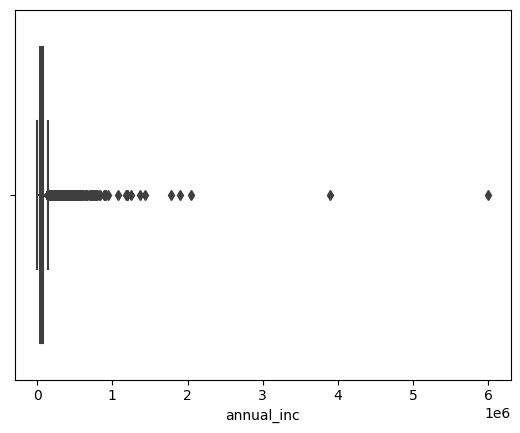

In [305]:
sns.boxplot(master["annual_inc"]);

In [306]:
master["annual_inc"].describe()

count     39717.00
mean      68968.93
std       63793.77
min        4000.00
25%       40404.00
50%       59000.00
75%       82300.00
max     6000000.00
Name: annual_inc, dtype: float64

Clearly there are way too many outlier values that woud skew the analysis. Thus we need to remove these outliers.

In [308]:
# Quantile Information for Annual Income.
qnt_info = master["annual_inc"].quantile([0.5,0.75,0.95,0.97,0.98,0.99])
print(qnt_info)

0.50    59000.00
0.75    82300.00
0.95   142000.00
0.97   165757.92
0.98   187000.00
0.99   234999.36
Name: annual_inc, dtype: float64


The values after 95th percentile are likely to mess up the analysis. Thus removing all values beyond the 95th percentile.

In [309]:
ann_inc_95 = master["annual_inc"].quantile(0.95)
master = master[master["annual_inc"] <= ann_inc_95]
master.shape

(37743, 52)

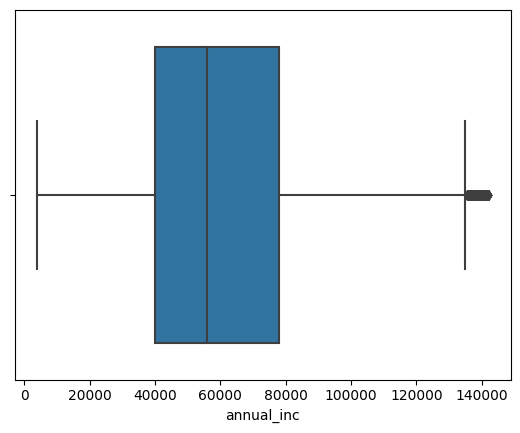

In [310]:
sns.boxplot(master["annual_inc"]);

This is a much cleaner boxplot with low number of outliers.

### Univariate Analysis

#### Analysis of Continuous Variables:

**Loan Amount**

count   39717.00
mean    11219.44
std      7456.67
min       500.00
5%       2400.00
10%      3200.00
25%      5500.00
50%     10000.00
75%     15000.00
90%     22000.00
95%     25000.00
99%     35000.00
max     35000.00
Name: loan_amnt, dtype: float64


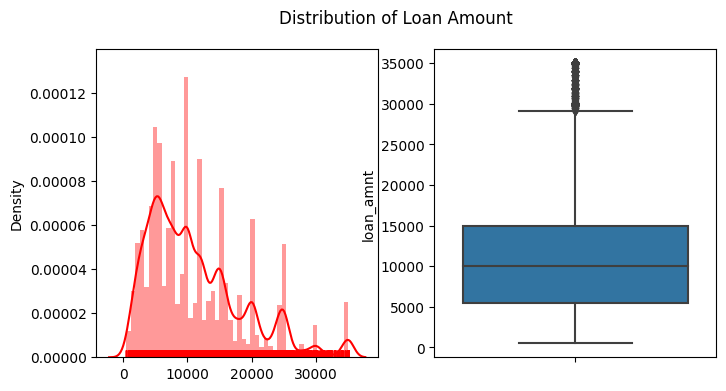

In [304]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
plt.suptitle("Distribution of Loan Amount")
sns.distplot(ax=ax[0],x=master["loan_amnt"],color='red',rug=True);
sns.boxplot(ax=ax[1],y=master["loan_amnt"]);

print(master["loan_amnt"].describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

*Observation*: <br>
It can be seen that majority of the loans that are given are in the range of $5000 to $15000 with only a minor amount of loans going beyond $35000.

**Funded Amount**:

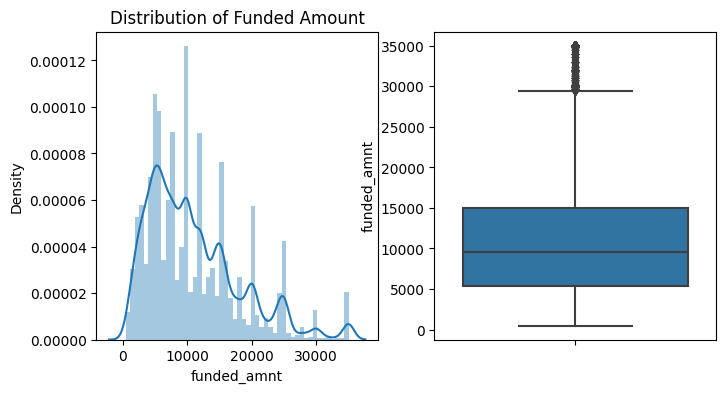

In [114]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].set_title("Distribution of Funded Amount")
sns.distplot(ax=ax[0],a=master["funded_amnt"])

sns.boxplot(ax=ax[1],y=master["funded_amnt"]);

*Observation*: <br>
Funded Amount is similar to the Loan amount of curve which indicates that Lending Club has approved most of the applicants.

**Amount Funded by investors** : <br>
The part of loan amount funded by investors.

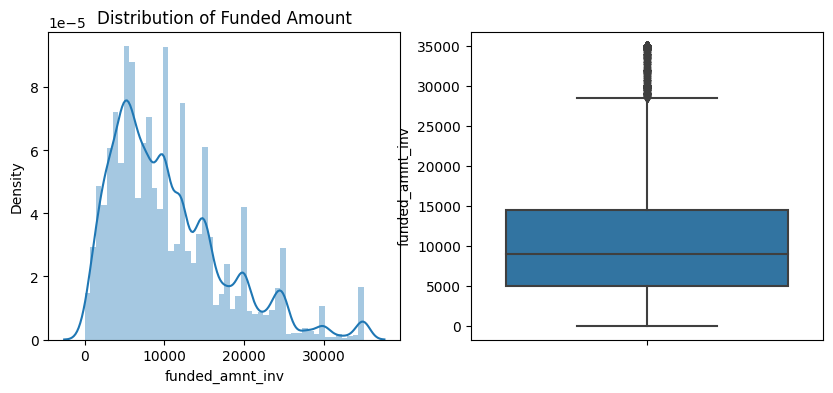

In [115]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].set_title("Distribution of Funded Amount")
sns.distplot(ax=ax[0],a=master["funded_amnt_inv"])

sns.boxplot(ax=ax[1],y=master["funded_amnt_inv"]);

*Observation*: <br>
Investors' funded amount behaves similar to the Loan amount. Which means Investors agreed to fund most of the applicants. 

**Approved Loan Amount ratio**: <br>
This is to compare the ratio of the money funded by investors and Lending Club.

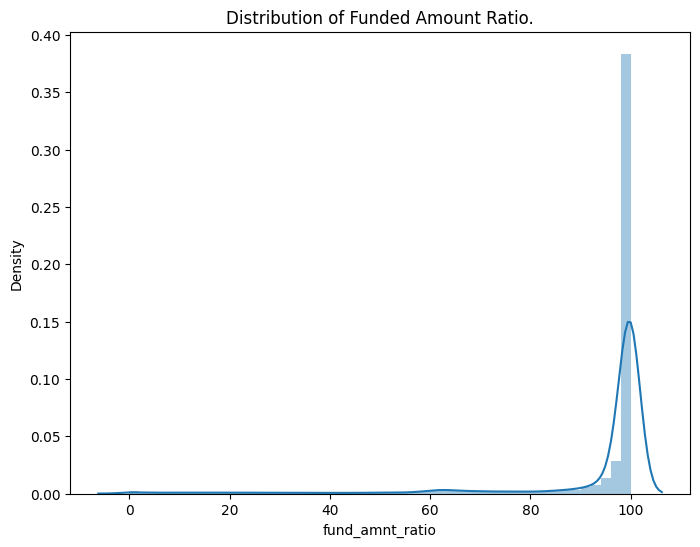

In [116]:
plt.figure(figsize=(6,4))
plt.title("Distribution of Funded Amount Ratio.")
sns.distplot(a=master["fund_amnt_ratio"]);

*Observation*: <br>
Investors fund majority of the total Loan amount. The ratio funded by investors could be anywhere between 80% to 100%.

**Interest Rate** 

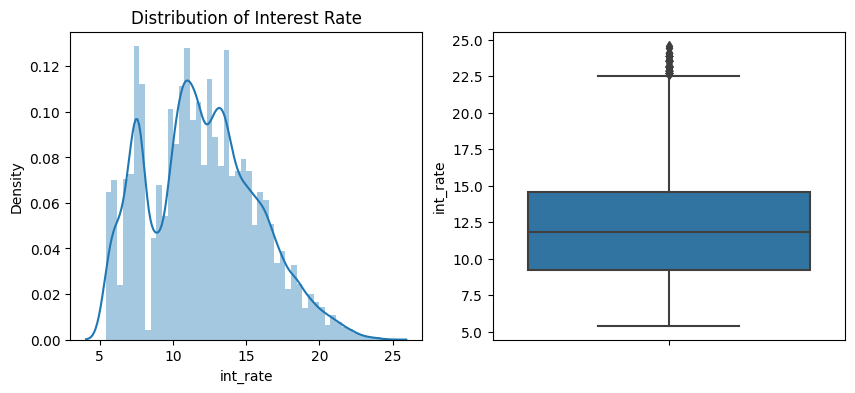

In [118]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title("Distribution of Interest Rate")
sns.distplot(ax=ax[0],a=master["int_rate"])
sns.boxplot(ax=ax[1],y=master["int_rate"]);

**Observation**: <Br>
Most of the interest rates lie between <b>9% to 15%</b>. Some loans were granted at high rates of more than **20%** .

**Annual Income**

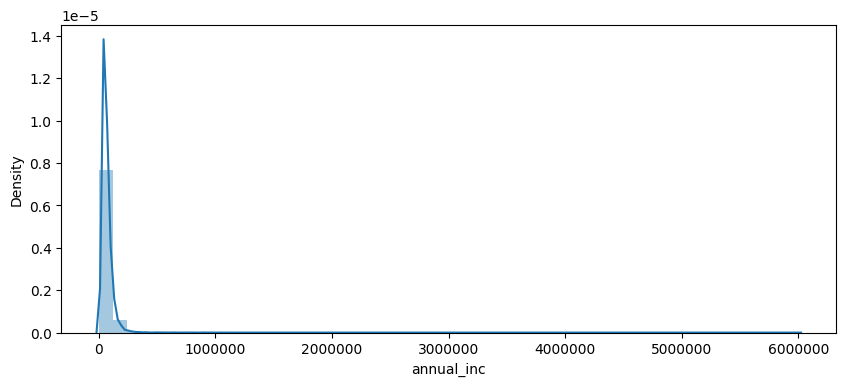

In [142]:
plt.figure(figsize=(10,4))
plt.ticklabel_format(axis='x',style='plain')
sns.distplot(a=master["annual_inc"])
plt.show();

**Loan Issue Date**

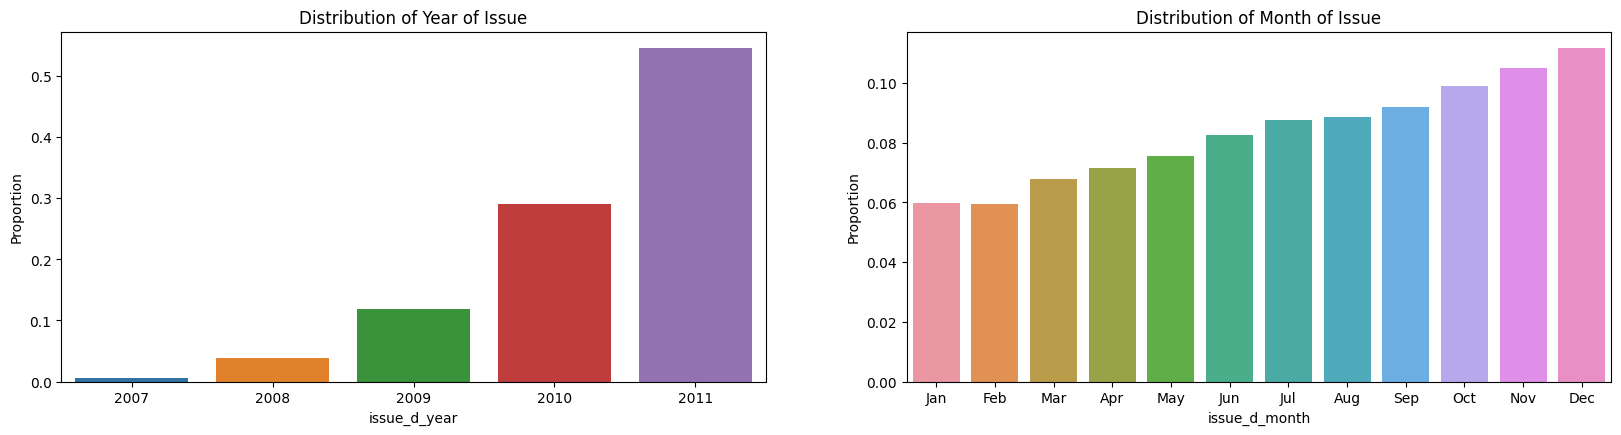

In [149]:
var = "issue_d_year"

# Percentage of each values:
perc_df = master[var].value_counts(normalize=True).reset_index()

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.barplot(x='index', y=var, data=perc_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title('Distribution of Year of Issue')

var = 'issue_d_month'

#Percentage of each value
perc_df = master[var].value_counts(normalize=True).reset_index()
plt.subplot(2,2,2)
sns.barplot(x='index', y=var, data=perc_df,order=months)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title('Distribution of Month of Issue')

plt.show();

*Observation*: <br>
The number of loans issued increased drastically in the years 2010 and 2011. This also matches with the recovery period after 2008 financial crisis triggered by the Lehman brothers.

**Earliest Credit Line**

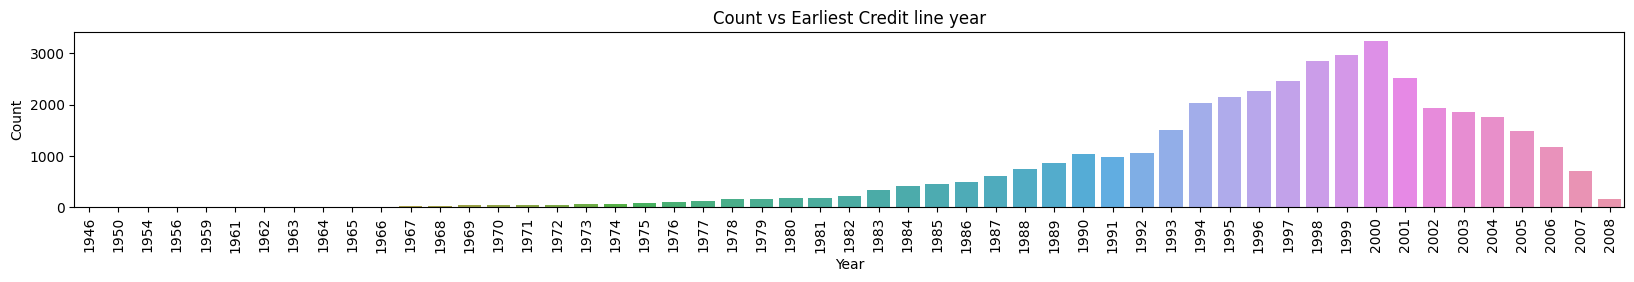

In [152]:
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
sns.countplot(master.earliest_cr_line_year)
plt.title('Count vs Earliest Credit line year')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show();

*Observation*: <br>
Many loans were given out in the period betweee 1994 and 2004. This was the phase of what is commonly known as "DOT COM BUBBLE" or the tech bubble due to rise of the Internet and other technologies like Microsoft, Apple etc.

**DTI** <br>
*Debt to Income Ratio* : <br>
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

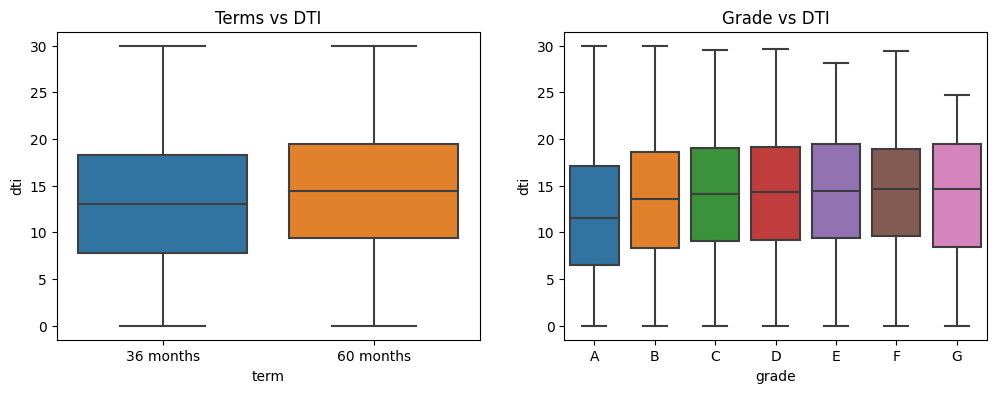

In [250]:
plt.figure(figsize=(12,4))

plt.subplot(121)
sns.boxplot(x='term', y="dti", data=master)
plt.title('Terms vs DTI')

plt.subplot(122)
plt.title('Grade vs DTI')
grade_ord = sorted(master["grade"].unique())

sns.boxplot(x='grade', y="dti", order = grade_ord, data=master);

*Observations* : <br>
DTI is higher for people with 60 months term length. The probable reason behind this is because people with higher DTI means they have higher debt, thus requiring bigger loan amounts to pay off the said debts. 

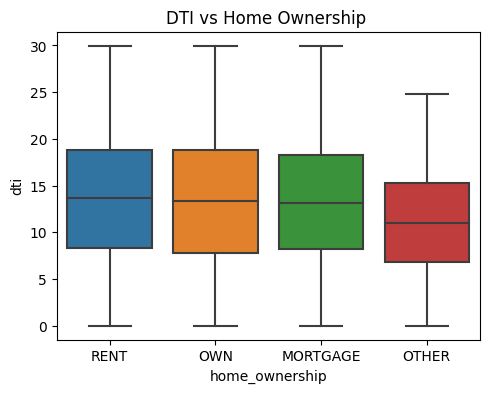

In [253]:
plt.figure(figsize=(12,4))
plt.title('DTI vs Home Ownership')
sns.boxplot(x='home_ownership', y="dti", data=master);

*Observation* :<br>
People in the OTHER category have slightly lesser DTI than people who rent, own or mortgaged their homes.

----

#### Analysis of Categorical Variables: 

**Written off applicants**: <br>
These applicants have already been charged off, which means LC will not get their money back from these appicants. Thus these applicants have made LC incur losses.

Fully Paid    0.83
Charged Off   0.14
Current       0.03
Name: loan_status, dtype: float64


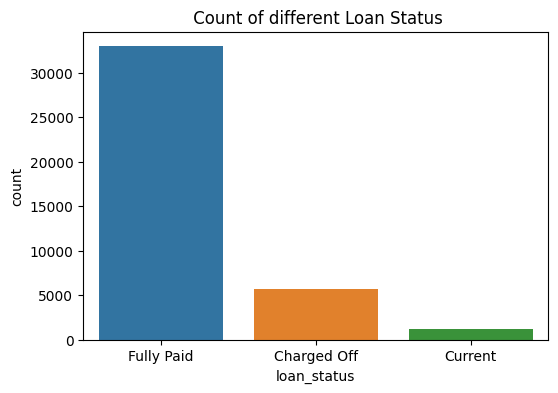

In [202]:
plt.figure(figsize=(6,4))
print(master["loan_status"].value_counts(normalize=True))
plt.title(" Count of different Loan Status")
sns.countplot(master["loan_status"]);

*Observation* : <br>
Around <b>14%</b> have already been written off by the company. This is slightly higher than the usual 8%-10% that financial companies keep as their write-off amount.

**Term** 

<AxesSubplot:title={'center':'Count of Term'}, xlabel='term', ylabel='count'>

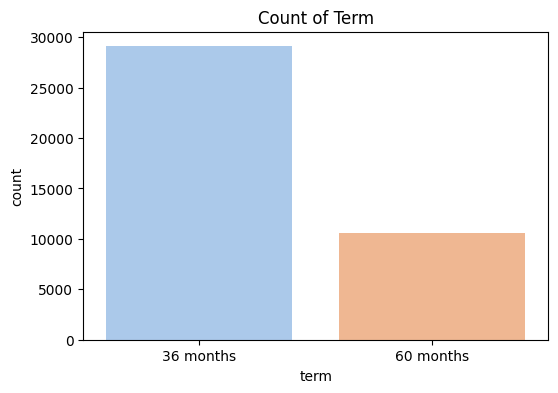

In [158]:
plt.figure(figsize=(6,4))
plt.title("Count of Term")
sns.countplot(master["term"],palette="pastel");

*Observation* : <br>
Most borrowers have 36 months of payback term. This coincides with the fact that most of the loan amounts are low in amount thus requiring lesser amount of time to payback.

**Grade and Subgrades** : <br>
The details of the Grades and Subgrades of the loans can be found below at -  <br>

https://www.lendingclub.com/foliofn/rateDetail.action <br>

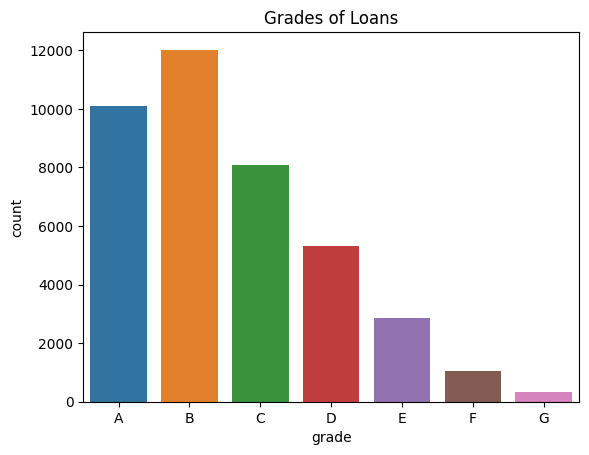

In [120]:
grades = master["grade"]
plt.title("Grades of Loans")
sns.countplot(grades,order=["A","B","C","D","E","F","G"]);

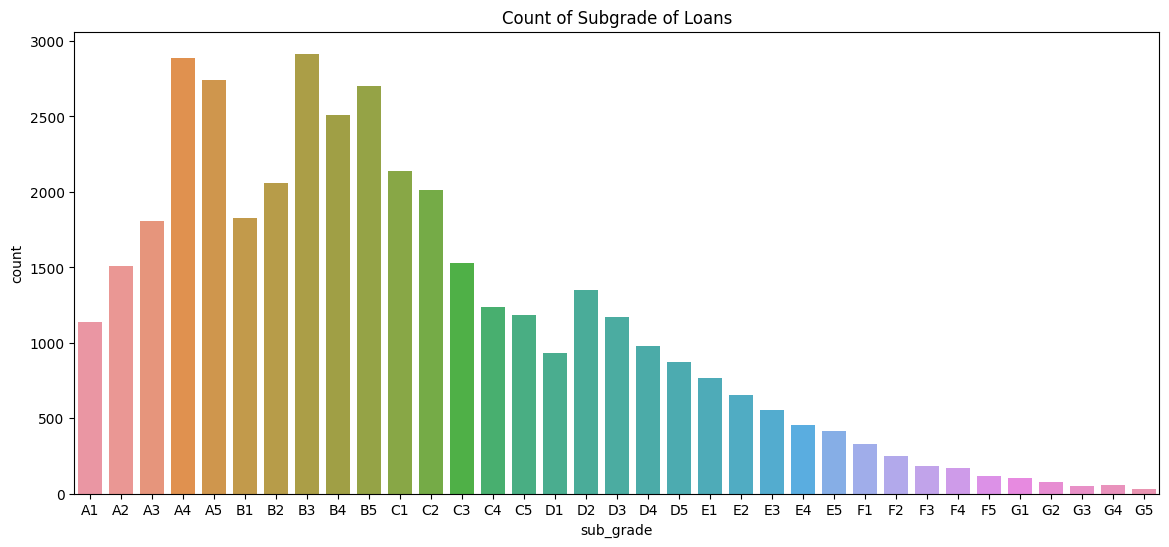

In [121]:
subgrade = master["sub_grade"]
subgrade.value_counts()
order = sorted(subgrade.value_counts().index)
plt.figure(figsize=(14,6))
plt.title("Count of Subgrade of Loans")
sns.countplot(subgrade,order=order);

As per the link above, B grade loans have a interest rate of <b>13.33%</b> to **16.08%** <i>(as of 7th Sep 2022)</i>.

**Employment Length** : <br>

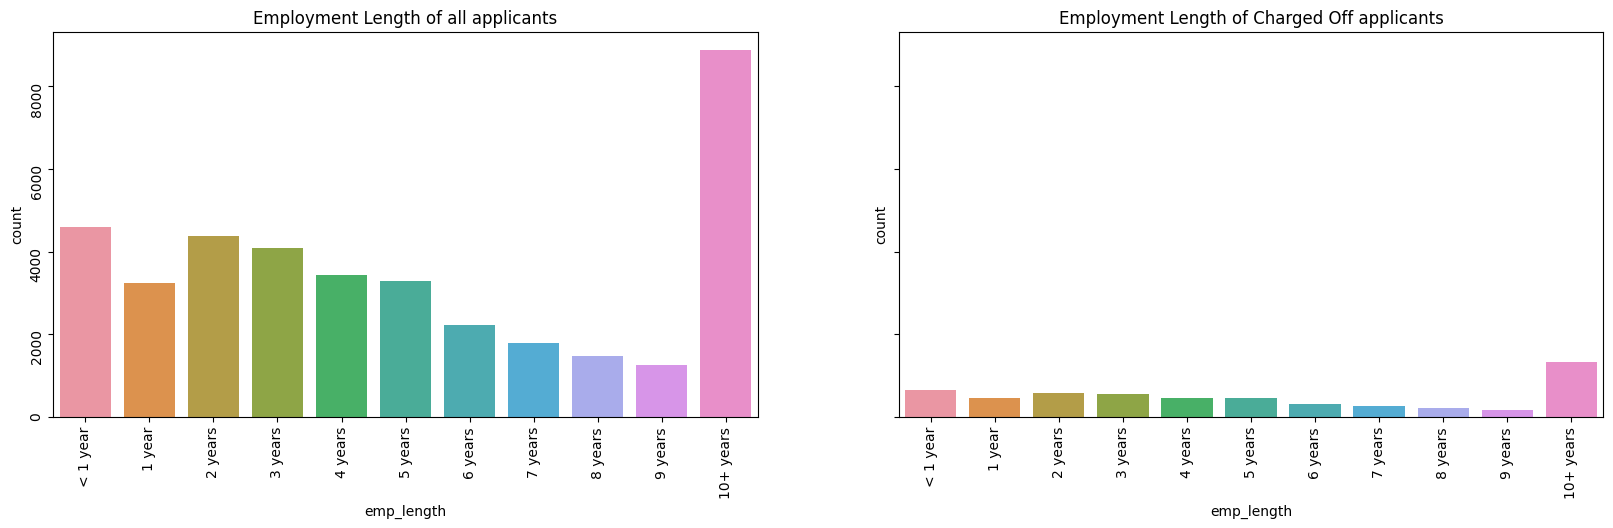

In [209]:
emp_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years","7 years", "8 years", "9 years", "10+ years"]

fig,ax=plt.subplots(1,2,figsize=(20,5),sharey=True)

ax[0].tick_params(labelrotation=90)
ax[0].set_title("Employment Length of all applicants")
sns.countplot(ax=ax[0],x=master["emp_length"],order=emp_order);

ax[1].tick_params(labelrotation=90)
ax[1].set_title("Employment Length of Charged Off applicants")
sns.countplot(ax=ax[1], x=charged_off["emp_length"],order=emp_order);

*Observation* : <br>
Lending Club is playing safe by giving a large number of loans to people who have a long term proven employment. But even amongst the charged-off applicants, the highest number is those have been employed for more than 10 years. But this is probably because dataset is skewed in favor of 10+ year applicants.

**Home Ownership**

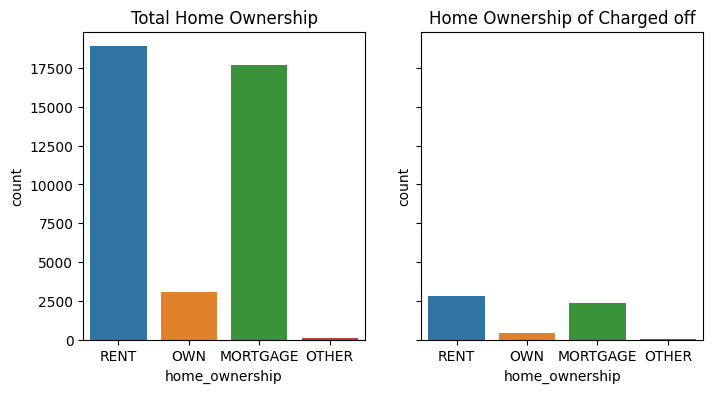

In [159]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharey=True)
ax[0].set_title("Total Home Ownership")
sns.countplot(ax=ax[0],x=master["home_ownership"]);

ax[1].set_title("Home Ownership of Charged off")
sns.countplot(ax=ax[1],x=charged_off["home_ownership"]);


*Inference*: <br>
In both the cases, the people who rent and mortgage their homes take a lot of loans. Even amongst the defaulters, the renters and mortgages are the risky ones. 

**Purpose**

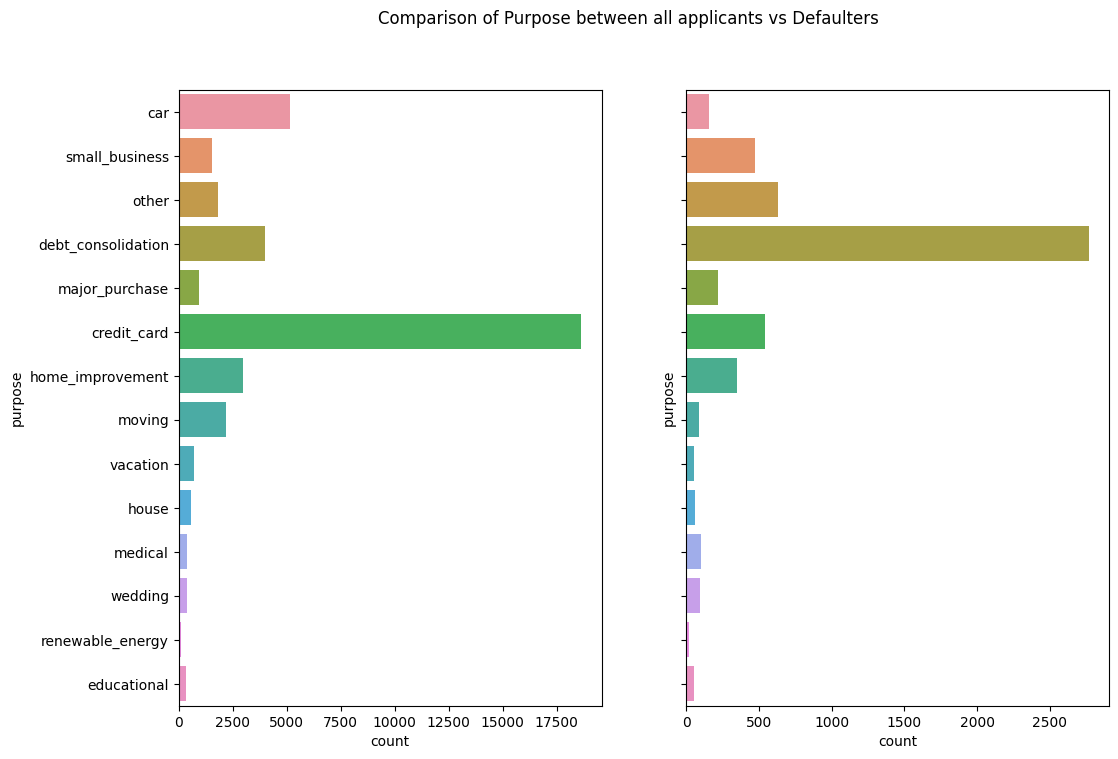

In [123]:
fig, ax = plt.subplots(1,2,figsize = (12,8),sharey=True)
plt.suptitle("Comparison of Purpose between all applicants vs Defaulters")
sns.countplot(ax=ax[0], y ='purpose', data=master)
sns.countplot(ax=ax[1], y ='purpose', data=charged_off)
plt.show();


*Inference*: <br>
Most of the loans seems to be taken for external debt consolidation. This means this money has been taken to pay off other loans - credit card or other loan payments. 


**States**

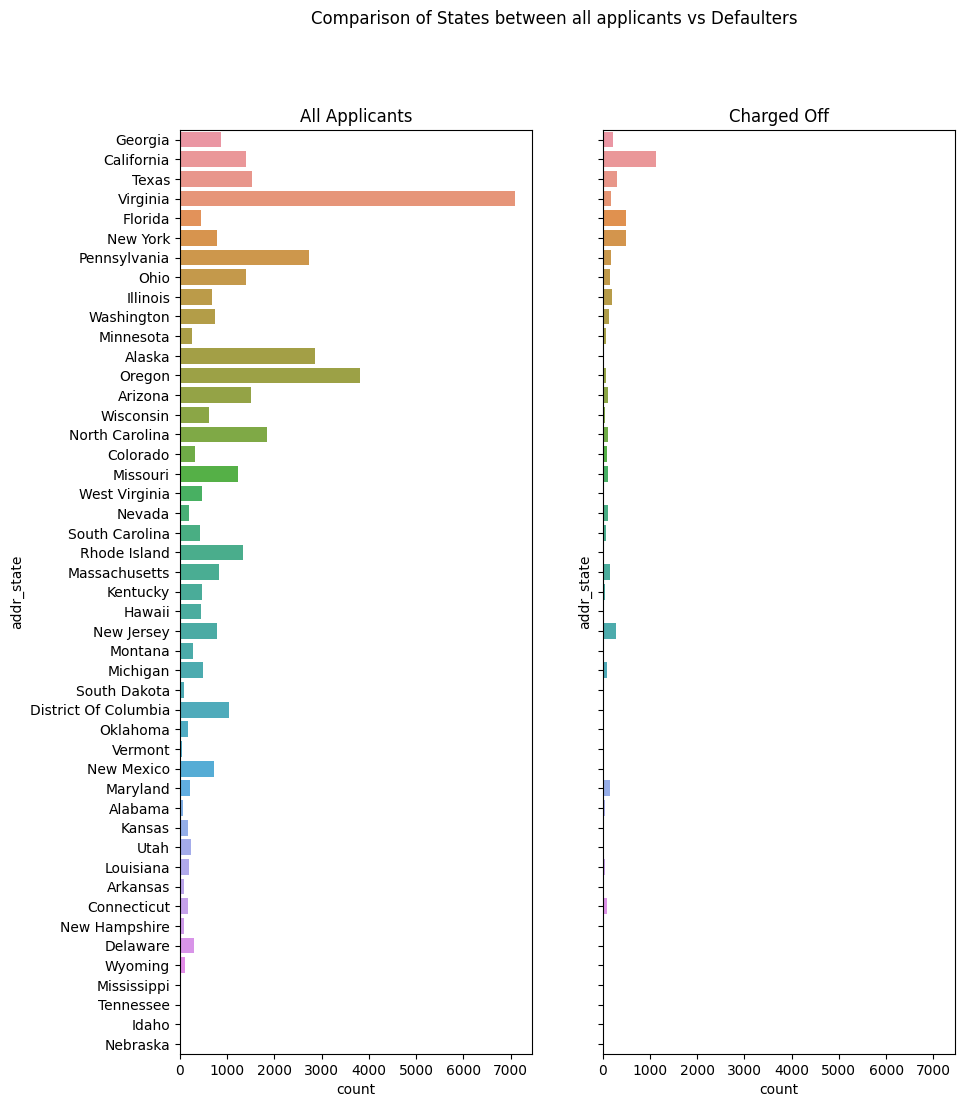

In [239]:
fig, ax = plt.subplots(1,2,figsize = (10,12),sharey=True,sharex=True)
plt.suptitle("Comparison of States between all applicants vs Defaulters")
ax[0].set_title("All Applicants")
sns.countplot(ax=ax[0], y ='addr_state', data=master)

ax[1].set_title("Charged Off")
sns.countplot(ax=ax[1], y ='addr_state', data=charged_off)
plt.show();


*Observation* : <br>
People from Virginia have taken maximum number of loans but the defaulters/Charged off candidates are from California.

**Interest Rate with bins**

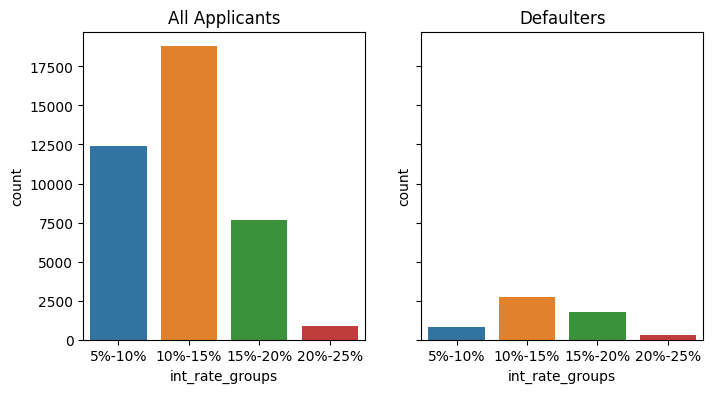

In [245]:
# Creating Interest Groups for all applicants and Charged off Applicants:
master['int_rate_groups'] = pd.cut(master['int_rate'], bins=[5,10,15,20,25],precision =0,labels=['5%-10%','10%-15%','15%-20%','20%-25%'])
charged_off['int_rate_groups'] = pd.cut(charged_off['int_rate'], bins=[5,10,15,20,25],precision =0,labels=['5%-10%','10%-15%','15%-20%','20%-25%'])

fig,ax=plt.subplots(1,2,figsize=(8,4),sharey=True)

ax[0].set_title("All Applicants")
sns.countplot(ax=ax[0],x=master["int_rate_groups"]);

ax[1].set_title("Defaulters")
sns.countplot(ax=ax[1],x=charged_off["int_rate_groups"]);


*Observations*: <br>
Most loans are given at 10%-15% which is grade B, followed by low interest rates of 5-10%. But most of the defaulters belond to 10-15%, followed by 15-20% group.


----

### Segmented Univariate Analysis:

**Loan Amount**

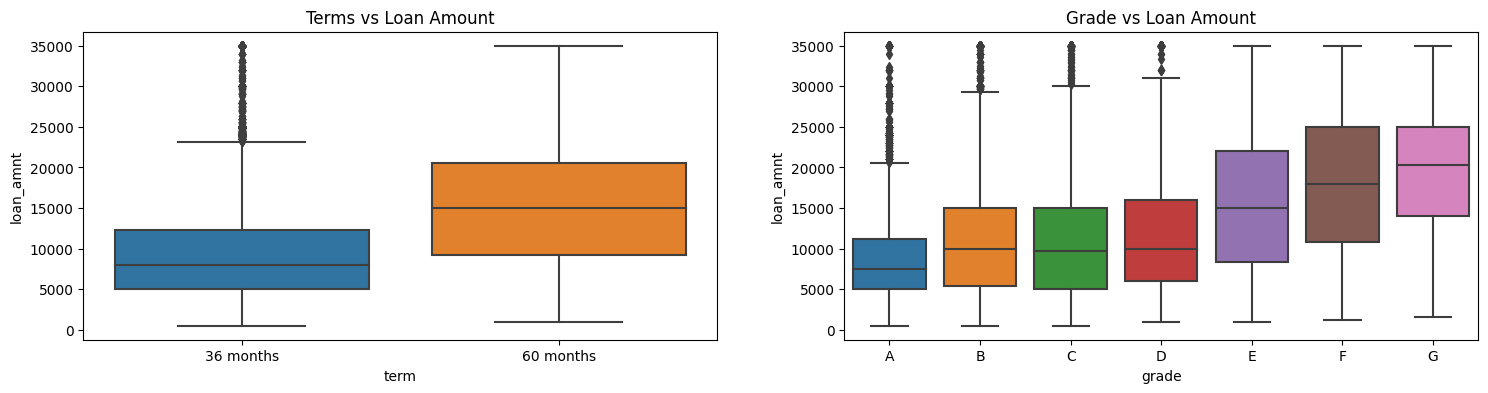

In [214]:
plt.figure(figsize=(18,4))
plt.subplot(121)
sns.boxplot(x='term', y=master.loan_amnt, data=master)
plt.title('Terms vs Loan Amount')
plt.subplot(122)
plt.title('Grade vs Loan Amount')
# Finding grades with sorted alphabetical order
grade_ord = master.grade.unique()
grade_ord.sort()
sns.boxplot(x='grade', y=master.loan_amnt, order=grade_ord, data=master);


<b>Inference</b>: <br>

High amount loans tend to have a high tenure i.e, 60 months. This is expected as borrowers are given ample time to return the loan. <br>

As per the link  - https://www.lendingclub.com/foliofn/rateDetail.action , grade G refers to high interest loans. Lending Club uses high interest rate on bigger loans to  reduce defaulting. 


**Home Ownership vs Loan Amount**

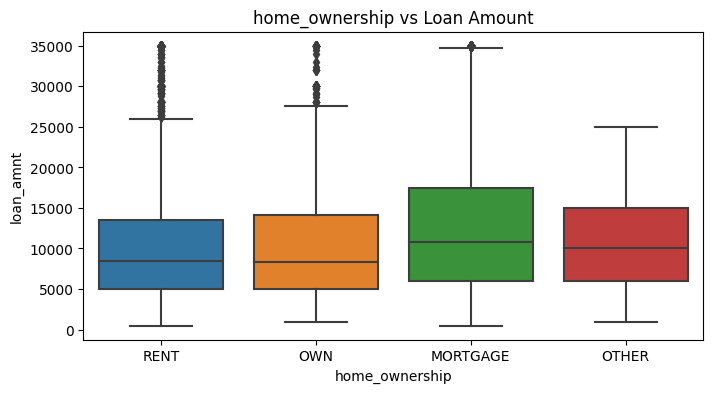

In [126]:
plt.figure(figsize=(8,4))
plt.title('home_ownership vs Loan Amount')
sns.boxplot(x='home_ownership', y=master.loan_amnt, data=master);


<b>Observations</b>:

Mortgage owners tend to have a lower appetite for loans, as the number of outliers is far lower than those of Rent and Owned. This is expected as they are already mortgaged and thus are unlikely to receive high loan amount due to lack of collateral. <br>
On the other hand, renters and owners have a higher appetite for loans, thus can take large amounts. 

**Length of Employment vs Loan Amount**

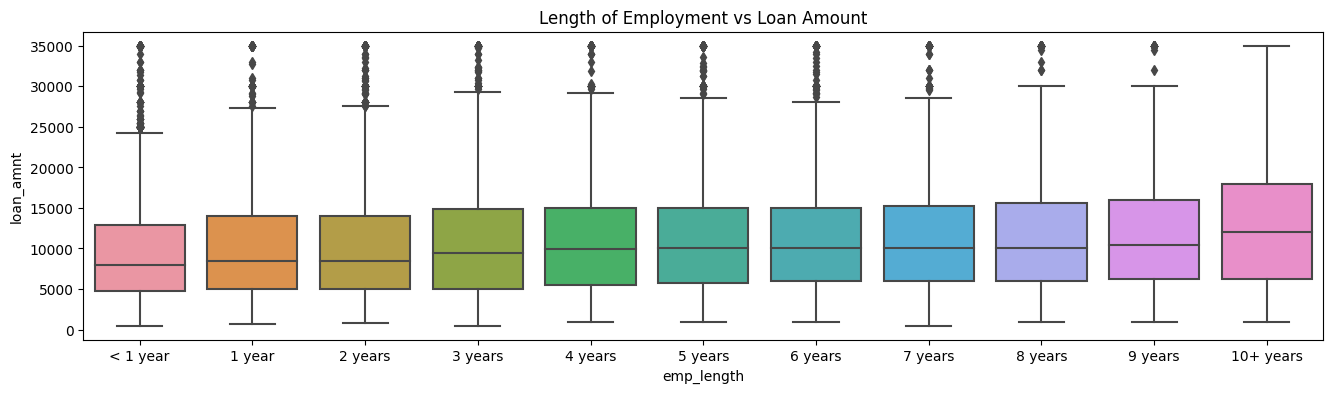

In [216]:
plt.figure(figsize=(16,4))
plt.title('Length of Employment vs Loan Amount')
sns.boxplot(x='emp_length', y=master.loan_amnt, data=master,order=emp_order);


<b>Observations</b>: <br>

People with more than 10+ years of employment tend to take higher amount of loans.

**Terms vs Funded Amount**

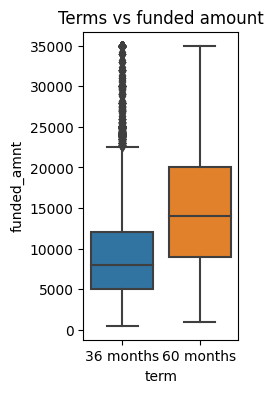

In [223]:
plt.figure(figsize=(2,4))
sns.boxplot(x='term', y="funded_amnt", data=master)
plt.title('Terms vs funded amount');

*Observation*: <br>
As expected, higher amount of loans have a higher payback time.

**Grade and Funded Amount**

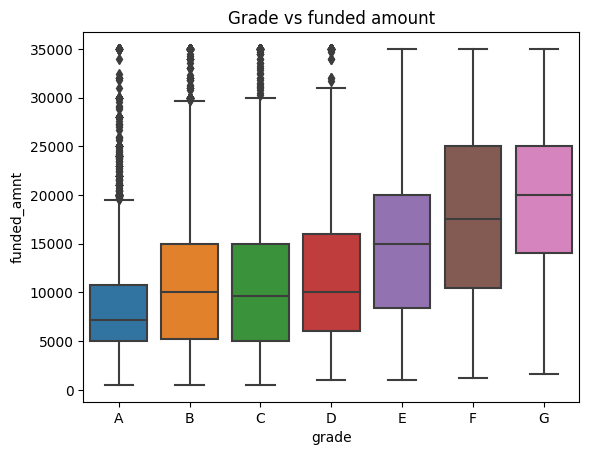

In [225]:
plt.title('Grade vs funded amount')
grade_ord = sorted(master.grade.unique())
sns.boxplot(x='grade', y="funded_amnt", order = grade_ord, data=master);

*Observations* : <br>
The details for grades are avaialble at https://www.lendingclub.com/foliofn/rateDetail.action . Grade G loans have the highest interest rates, and thus is applied to higher loan amounts.

---

### Bivariate Analysis

Term vs Loan Status

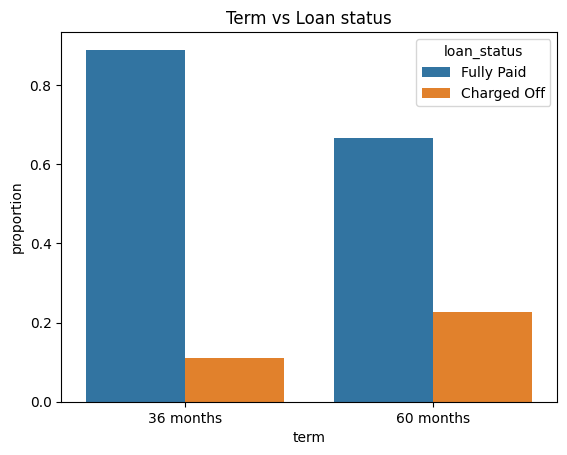

In [129]:
#Proportion of values for each category
df = master.groupby(['term', 'loan_status'], as_index=False)['id'].count()
df['proportion'] = df.groupby('term').transform(lambda x: x/x.sum())
plt.title('Term vs Loan status')
sns.barplot(x='term', y='proportion', hue='loan_status', data=df, hue_order = ['Fully Paid', 'Charged Off']);


<b>Observation</b>: <br>
- The number of defaulters are more for the loans with 60 months payback period.
- The loans with 36 months have higher pay-off rate than that of 60 months. This is expected as loans with smaller amounts have shorter time period and is easier to payback

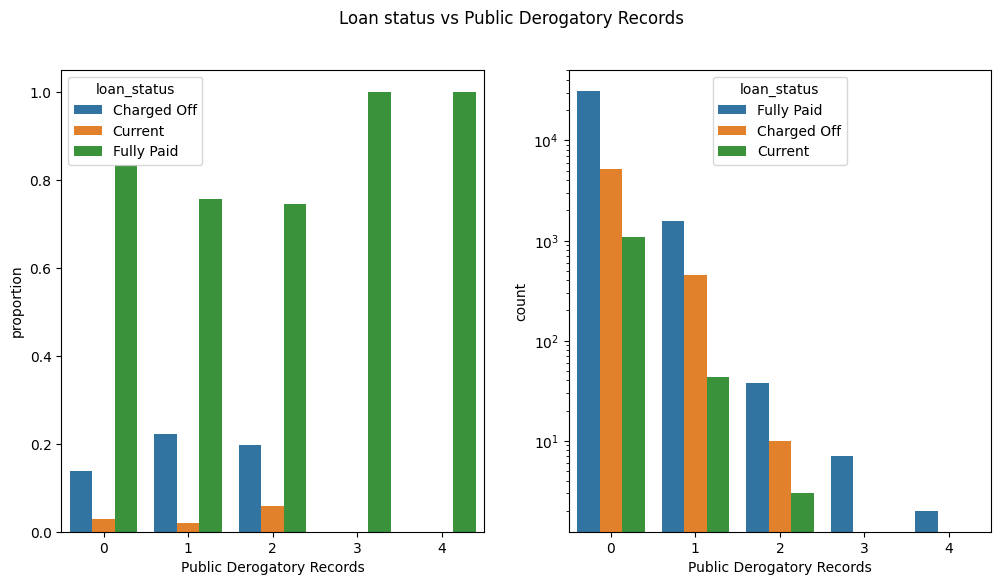

In [263]:
# Proportion of values for each category
df = master.groupby(['pub_rec', 'loan_status'], as_index=False)['id'].count()
df['proportion'] = df.groupby('pub_rec').transform(lambda x: x/x.sum())

plt.figure(figsize=(12,6))
plt.subplot(121)
sns.barplot(x='pub_rec', y='proportion', hue='loan_status', data=df)
plt.xlabel("Public Derogatory Records")

plt.subplot(122)
sns.countplot(master.pub_rec, hue='loan_status', data=master)
plt.yscale('log')
plt.xlabel("Public Derogatory Records")
plt.suptitle('Loan status vs Public Derogatory Records')

plt.show();

*Observations* : <br>
- There are no Charged off applicants with 3 or 4+ records. This basically implies that Lending Club doesn't generally give loans to people with high number of derogatory records.
- People with low (0 to 1) records tend to pay off their loan.

**DTI groups**

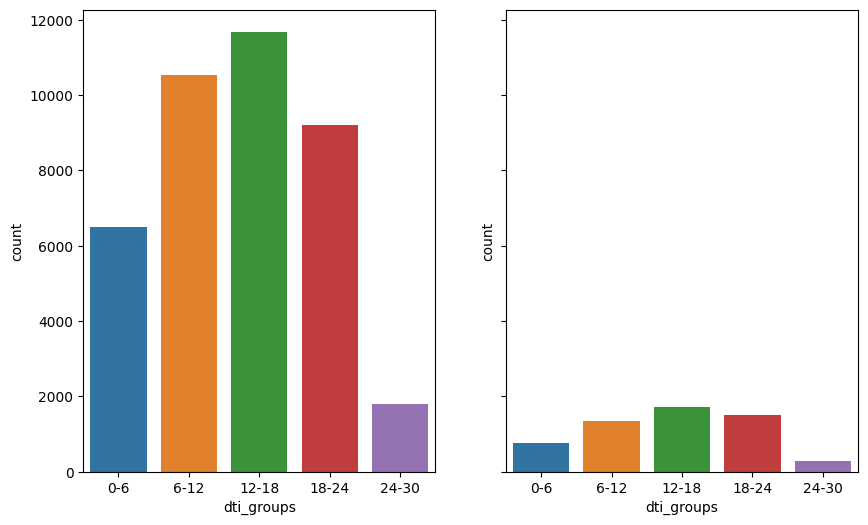

In [287]:
master['dti_groups'] = pd.cut(master['dti'], bins=5,precision =0,labels=['0-6','6-12','12-18','18-24','24-30'])
charged_off['dti_groups'] = pd.cut(charged_off['dti'], bins=5,precision =0,labels=['0-6','6-12','12-18','18-24','24-30'])


fig,ax = plt.subplots(1,2,figsize=(10,6),sharey=True)

sns.countplot(ax=ax[0], x = master["dti_groups"])
sns.countplot(ax=ax[1], x = charged_off["dti_groups"]);

**Annual Income Groups**

In [ ]:
master['annual_inc_groups'] = pd.cut(master['annual_inc'], bins=5,precision =0,labels =['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])
charged_off['annual_inc_groups'] = pd.cut(charged_off['annual_inc'], bins=5,precision =0,labels =['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])

### Inferences: <br>

From the above analysis with respect to the charged off loans for each variable suggests the following. There is a more probability of defaulting when :
- Applicants having house_ownership as 'RENT'
- Applicants who use the loan to clear other debts
- Applicants who receive interest at the rate of 13-17%
- Applicants who have an income of range 31201 - 58402
- Applicants who have 20-37 open_acc
- Applicants with employement length of 10
- When funded amount by investor is between 5000-10000
- Loan amount is between 5429 - 10357
- Dti is between 12-18
- When monthly installments are between 145-274
- Term of 60 months
- When the loan status is Not verified
- When the no of enquiries in last 6 months is 0
- When the number of derogatory public records is 0
- When the purpose is 'debt_consolidation'
- Grade is 'B'
- And a total grade of 'B5' level.